In [1]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
import threading

In [2]:
#hyper parameters
t_max = 10
gamma = 0.99
learning_rate = 0.001
beta = 0.1

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
actions = [ -2 + 0.4*i for i in range(11)]

print(actions)

[-2.0, -1.6, -1.2, -0.7999999999999998, -0.3999999999999999, 0.0, 0.40000000000000036, 0.8000000000000003, 1.2000000000000002, 1.6, 2.0]


In [4]:
class policy_net(nn.Module):
    def __init__(self, input_feature, num_action):
        super(policy_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 128, out_features = num_action)
        

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.linear2(x)
        policy = F.softmax(x,dim=0)
        return policy
    
class value_net(nn.Module):
    def __init__(self, input_feature):
        super(value_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 128, out_features = 1)

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.linear2(x)
        return x
    
    
    

In [5]:

def get_action_idx(num_action, policy):
    return np.random.choice(num_action, 1, p=policy.detach().numpy()).item()



In [6]:
#multihtread
p_net_shared = policy_net(3,11)
v_net_shared = value_net(3)
np.random.seed(seed)
torch.manual_seed(seed)

reward_plot = [0 for i in range(1000)]

_lock = threading.Lock()


def training(idx):
    t_max = 5
    gamma = 0.9
    learning_rate = 0.001
    beta = 0
    num_action = 11
    step = 0
    state = []
    
    env = gym.make('Pendulum-v0')

    global p_net_shared
    global v_net_shared
    p_optimizer = optim.Adam(p_net_shared.parameters(), lr=learning_rate)
    v_optimizer = optim.Adam(v_net_shared.parameters(), lr=learning_rate)
    global reward_plot
    
    for iteration in range(1000):
        done = False
        observation = env.reset()
        state = observation
        
        p_net = policy_net(3,num_action)
        v_net = value_net(3)
    
        p_net.zero_grad()
        v_net.zero_grad()
        
        t_update = 0
        #beta -= 0.0003
        #learning_rate -= 0.0009/2000
        if(iteration>2000):
            learning_rate = 0.0001
        if(beta<=0):
            beta = 0
        reward_stack = []
        prob_stack = []
        value_stack = []
        entropy = 0
        reward_sum = 0
        policy_loss_sum=0
        value_loss_sum = 0
        for t in range(10000):

            step = step+1

            policy= p_net(torch.Tensor(state))
            value = v_net(torch.Tensor(state))
            action_idx = get_action_idx(num_action, policy)
            action = -2 + 0.4 * action_idx
            
            next_state , reward, done, info = env.step([action])
            reward /= 16.2736044
            reward_sum += reward
            t_update += 1

            reward_stack.append(reward)
            value_stack.append(value)
            prob_stack.append(policy[action_idx])
            
            entropy += -torch.sum(policy * torch.log(torch.clamp(policy,min=1e-6)))

            if(t_update >= t_max or done):
                R = v_net(torch.Tensor(next_state))
                policy_loss = 0
                value_loss = 0
                

                for i in range(t_update):
                    R = R*gamma + reward_stack.pop()
                    value_temp = value_stack.pop()
                    policy_loss += -torch.log(torch.clamp(prob_stack.pop(),min=1e-6)) * (R-value_temp).detach()
                    value_loss += (R-value_temp) * (R-value_temp)
                    
                entropy = -entropy * beta
                policy_loss = policy_loss/t_max + entropy / t_max
                value_loss = value_loss /t_max
                
                _lock.acquire()
                
                policy_loss.backward(retain_graph=True)
                value_loss.backward()
                
                policy_loss_sum += policy_loss.detach().numpy()
                value_loss_sum += value_loss.detach().numpy()

                for p_param , s_p_param , v_param , s_v_param in zip(p_net.parameters(), p_net_shared.parameters(), v_net.parameters(), v_net_shared.parameters()):
                    
                    s_p_param._grad = p_param.grad.detach()
                    s_v_param._grad = v_param.grad.detach()
                    if((s_p_param != s_p_param).any()):
                        print("explode !!!! ")
                    
                
                p_optimizer.step()
                v_optimizer.step()
                p_net_shared.zero_grad()
                v_net_shared.zero_grad()
                
                _lock.release()
                
                p_net = policy_net(3,num_action)
                v_net = value_net(3)    

                p_net.load_state_dict(p_net_shared.state_dict())
                v_net.load_state_dict(v_net_shared.state_dict())
                R=0
                entropy = 0
                t_update = 0
            if(done):
                break

            #env.render()
            state = next_state[:]
        reward_plot[iteration] += reward_sum
        if(iteration%10 ==0):
            print(policy_loss_sum)
            print(value_loss_sum)
            print("training idx {} actor true_reward at iteration {} : {}".format(idx,iteration, reward_sum))
            print(step)
            beta = beta * 0.99
th1 = threading.Thread(target = training , args = (1,))
th2 = threading.Thread(target = training , args = (2,))
th3 = threading.Thread(target = training , args = (3,))
'''th4 = threading.Thread(target = training , args = (4,))'''
th1.start()
th2.start()
th3.start()
'''th4.start()'''

th1.join()
th2.join()
th3.join()
'''th4.join()'''

print("finish")

/home/wooseoko/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[-65.95397]
[46.61192]
training idx 2 actor true_reward at iteration 0 : -86.23764270684784
200
[-69.51836]
[42.425415]
training idx 3 actor true_reward at iteration 0 : -85.42556627339141
200
[-63.119434]
[39.271965]
training idx 1 actor true_reward at iteration 0 : -84.50338139012719
200
[-3.291564]
[4.2019596]
training idx 3 actor true_reward at iteration 10 : -65.4303788257255
2200
[0.33006334]
[3.287274]
training idx 2 actor true_reward at iteration 10 : -65.73870840446129
2200
[5.308979]
[2.783502]
training idx 1 actor true_reward at iteration 10 : -62.65439417078362
2200
[-10.0645485]
[3.9709704]
training idx 3 actor true_reward at iteration 20 : -98.20591664788738
4200
[2.6671398]
[2.6254346]
training idx 2 actor true_reward at iteration 20 : -47.35667716811039
4200
[-1.8712815]
[1.1485254]
training idx 1 actor true_reward at iteration 20 : -65.3746512132714
4200
[-2.9258318]
[2.3387127]
training idx 3 actor true_reward at iteration 30 : -62.61533790152008
6200
[1.120223]
[1.66

[-4.1789083]
[3.0892088]
training idx 1 actor true_reward at iteration 270 : -26.276882052570542
54200
[-0.29549444]
[0.26162267]
training idx 3 actor true_reward at iteration 270 : -8.036927063067695
54200
[-2.1985576]
[1.1689106]
training idx 2 actor true_reward at iteration 270 : -15.881113797475031
54200
[-2.299574]
[1.2409399]
training idx 1 actor true_reward at iteration 280 : -16.426059682222366
56200
[-0.31466228]
[0.92260283]
training idx 3 actor true_reward at iteration 280 : -7.908654284831643
56200
[-3.8773706]
[2.4808114]
training idx 2 actor true_reward at iteration 280 : -23.421814792434922
56200
[-3.0465462]
[1.5892204]
training idx 1 actor true_reward at iteration 290 : -16.123262992111236
58200
[-3.58103]
[2.4773774]
training idx 3 actor true_reward at iteration 290 : -26.662294094768512
58200
[-2.5334947]
[1.906721]
training idx 2 actor true_reward at iteration 290 : -16.048039807859798
58200
[-1.6003333]
[0.6000662]
training idx 1 actor true_reward at iteration 300 

KeyboardInterrupt: 

Text(0.5, 1.0, 'reward')

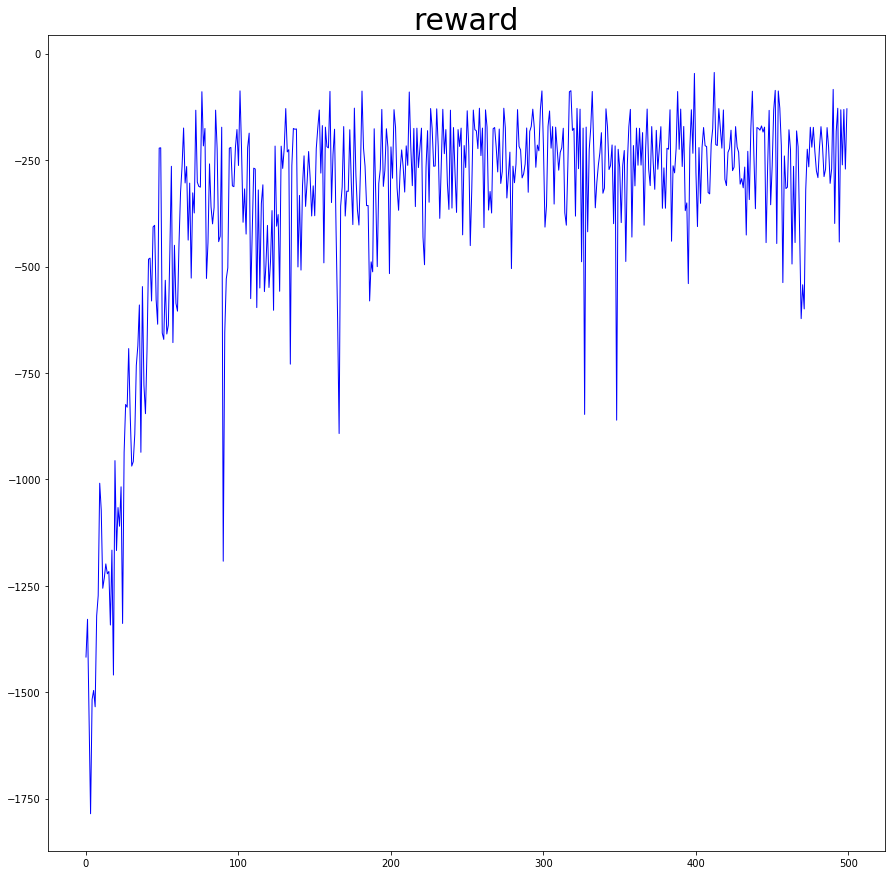

[-0.45638004]
[0.27286825]
training idx 1 actor true_reward at iteration 510 : -7.909122745670169
102200
[0.42619127]
[0.37843308]
training idx 3 actor true_reward at iteration 510 : -8.382546219325716
102200
[-0.5184754]
[0.3408664]
training idx 2 actor true_reward at iteration 510 : -23.97156431075512
102200
[-0.17070751]
[0.24773742]
training idx 1 actor true_reward at iteration 520 : -7.824921792184821
104200
[-2.3409297]
[1.2993219]
training idx 3 actor true_reward at iteration 520 : -15.577378205133229
104200
[-1.0108215]
[0.17072275]
training idx 2 actor true_reward at iteration 520 : -7.84238258396554
104200
[-1.4799165]
[0.6347668]
training idx 1 actor true_reward at iteration 530 : -15.839208050147077
106200
[-0.16151205]
[0.00539756]
training idx 3 actor true_reward at iteration 530 : -0.13046990507637843
106200
[-2.650467]
[1.2405745]
training idx 2 actor true_reward at iteration 530 : -16.631605015082968
106200


In [7]:
reward_np = np.array(reward_plot[:500]) * 16.6 /3
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)


In [8]:
#test
state = []
env = gym.make('Pendulum-v0')
done = False
reward_sum=0
observation = env.reset()
state = observation
num_action = 11

for t in range(10000):
    env.render()
    
    policy= p_net_shared(torch.Tensor(state))
    value = v_net_shared(torch.Tensor(state))

    action_idx = get_action_idx(num_action, policy)
    action = -2 + 0.4 * action_idx
    obs , reward, done, info = env.step([action])
    
    
    reward_sum = reward_sum + reward
    state=obs
    if done:
        break
    
print("reward {}".format(reward_sum))

reward -256.06992110235655
[0.03895727]
[0.0044489]
training idx 1 actor true_reward at iteration 540 : -0.11636130629978883
108200
[-0.4717937]
[0.41670683]
training idx 3 actor true_reward at iteration 540 : -7.7455294160607755
108200
[0.7230763]
[3.7460616]
training idx 2 actor true_reward at iteration 540 : -24.098854052192394
108200
[-1.3791155]
[0.56031877]
training idx 1 actor true_reward at iteration 550 : -15.485732376514623
110200
[-3.9428258]
[4.9321136]
training idx 3 actor true_reward at iteration 550 : -62.803573819625335
110200
[-2.1364875]
[0.6836296]
training idx 2 actor true_reward at iteration 550 : -7.810469831340764
110200
[-2.0978432]
[0.86320025]
training idx 1 actor true_reward at iteration 560 : -15.3862200500465
112200
[-2.0549212]
[0.8693866]
training idx 3 actor true_reward at iteration 560 : -16.22725519132415
112200
[-3.01529]
[1.5179684]
training idx 2 actor true_reward at iteration 560 : -24.8695442067038
112200
[-2.6472056]
[1.5514247]
training idx 1 ac